In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [57]:
split = pd.read_excel('eCM212-raw.xlsx')
split
# Select only the last column
gfp = split.iloc[:,-1]
split = split[['well']]
split['GFP'] = gfp
split
key = pd.read_csv('eCM212-key.csv')

letters = ['A','B','C','D','E',
           'F','G','H','I','J',
           'K','L','M','N','O','P']
numbers = [str(n+1) for n in range(24)]
comb = list(itertools.product(*[letters,numbers]))
comb = [''.join(l) for l in comb]

def assign_well(well_id):
    return comb[well_id]

key['well'] = key['well_id'].apply(assign_well)
key = key.drop(columns=['well_id','water','wce'])
all_data = pd.merge(split,key,on='well')
all_data = all_data.drop(columns=['well'])
# Round all lipo data to 2 decimal places
all_data['lipo'] = all_data['lipo'].round(2)
all_data

,GFP,bR_G,lipo,mCherry
0,737,15.0,3.03,2.0
1,885,0.0,0.61,2.0
2,2095,0.5,3.03,0.0
3,873,3.0,0.00,2.0
4,1164,0.0,0.00,2.0
...,...,...,...,...
91,1245,0.5,0.61,0.0
92,1886,3.0,0.61,0.0
93,727,15.0,0.61,2.0
94,582,0.0,3.03,0.0


In [58]:
# Remove outliers based on standard deviation of replicates of the same condition
condition_names = ['bR_G','lipo','mCherry']
calcs_out = []
n_stds = 2

def gfp_out(row):
    if row['GFP'] > bounds[0] and row['GFP'] < bounds[1]:
        return 0
    else:
        return 1

for v, v_df in all_data.groupby(condition_names):
    y = v_df['GFP']
    bounds = [np.median(y) - (n_stds*np.std(y)), np.median(y) + (n_stds*np.std(y))]
    v_df['GFP_out'] = v_df.apply(gfp_out,axis=1)
    calcs_out.append(v_df)
calcs_out = pd.concat(calcs_out)
calcs_out.value_counts('GFP_out')



GFP_out
0    92
1     4
Name: count, dtype: int64

In [59]:
good = calcs_out[calcs_out['GFP_out'] == 0]
good = good.drop(columns=['GFP_out'])
background = good[good['bR_G'] == 0]
background = background.groupby(['lipo','mCherry'])['GFP'].mean().reset_index()
background = background.rename(columns={'GFP':'background'})
good = pd.merge(good,background,on=['lipo','mCherry'])
good['GFP_sub'] = good['GFP'] - good['background']

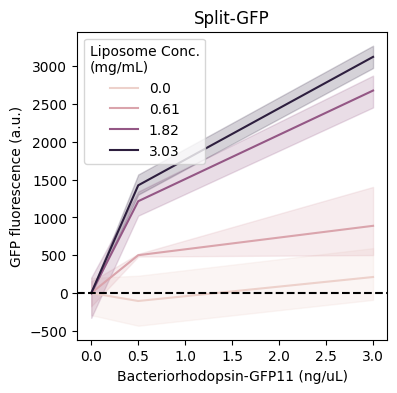

In [92]:
temp = good[good['bR_G'] < 10].copy()
temp = temp[temp['mCherry'] == 2]
fig, ax = plt.subplots(figsize=(4,4))
temp = temp.rename(columns={'lipo':'Liposome Conc.\n(mg/mL)'})
sns.lineplot(data=temp,x='bR_G',y='GFP_sub',hue='Liposome Conc.\n(mg/mL)',ax=ax)

# sns.scatterplot(data=temp,x='bR_G',y='GFP_sub',hue='lipo',ax=ax)
# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Bacteriorhodopsin-GFP11 (ng/uL)')
plt.ylabel('GFP fluorescence (a.u.)')
plt.title('Split-GFP')





plt.show()

In [61]:
condition_high = {
    'bR_G': 3,
    'lipo': 3.03,
    'mCherry': 2
}
condition_low = {
    'bR_G': 3,
    'lipo': 0,
    'mCherry': 2
}

# Calculate the fold change between the two conditions
high = good[(good['bR_G'] == condition_high['bR_G']) & (good['lipo'] == condition_high['lipo']) & (good['mCherry'] == condition_high['mCherry'])]
low = good[(good['bR_G'] == condition_low['bR_G']) & (good['lipo'] == condition_low['lipo']) & (good['mCherry'] == condition_low['mCherry'])]
high = high['GFP_sub'].mean()
low = low['GFP_sub'].mean()
fold_change = high/low
fold_change

14.730345911949687

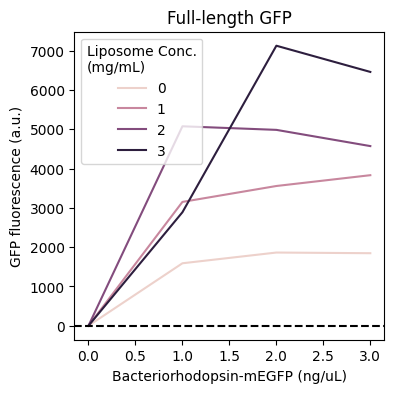

In [93]:
full = pd.read_excel('full_length_GFP_data.xlsx')
full
background = full[full['bR_G'] == 0]
background = background.groupby(['lipo'])['GFP'].mean().reset_index()
background = background.rename(columns={'GFP':'background'})
full = pd.merge(full,background,on=['lipo'])
full['GFP_sub'] = full['GFP'] - full['background']
temp = full[full['bR_G'] < 4].copy()
temp = temp[temp['lipo'] < 4]
temp = temp.rename(columns={'lipo':'Liposome Conc.\n(mg/mL)'})

fig, ax = plt.subplots(figsize=(4,4))

sns.lineplot(data=temp,x='bR_G',y='GFP_sub',hue='Liposome Conc.\n(mg/mL)',ax=ax)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Bacteriorhodopsin-mEGFP (ng/uL)')
plt.ylabel('GFP fluorescence (a.u.)')
plt.title('Full-length GFP')


plt.show()


In [71]:
condition_high = {
    'bR_G': 3,
    'lipo': 3,
}
condition_low = {
    'bR_G': 3,
    'lipo': 0,
}

# Calculate the fold change between the two conditions
high = full[(full['bR_G'] == condition_high['bR_G']) & (full['lipo'] == condition_high['lipo'])]
low = full[(full['bR_G'] == condition_low['bR_G']) & (full['lipo'] == condition_low['lipo'])]
high = high['GFP_sub'].mean()
low = low['GFP_sub'].mean()
fold_change = high/low
fold_change

3.5